## 预测工程：标记历史样本

在这个笔记本中，我们将开发一种方法来标记客户交易数据，用于解决客户流失预测问题。标记的目的是创建一组历史示例，这些示例是我们希望根据业务需求进行预测的依据：在这个问题中，我们的目标是预测客户流失，因此我们希望从数据中创建过去流失的标记示例。

这个笔记本的最终结果是一组标签，每个标签都带有相关的截止时间，存储在一个称为标签时间表的表格中。这些带有截止时间的标签稍后可以用于 Featuretools 进行自动化特征工程。这些特征又将用于训练预测模型，以预测客户流失，这对于基于订阅的商业模式来说是一种常见需求，也是机器学习非常适合解决的问题之一。

预测工程的过程如下所示：

![jupyter](pictures/预测工程图.png)

该图展示了一个预测工程（Prediction Engineering）的核心流程，它从 业务需求（Business Need） 出发，利用 历史数据（Historical Data），通过 预测工程（Prediction Engineering） 的处理，最终生成带有标签的 标签时间表（Label Times Table），以便后续进行 特征工程（Feature Engineering）。

### 流失的定义：预测问题  
流失的定义是指客户在一定天数内没有有效的活动会员资格。天数和何时进行预测被留作参数，可以根据特定的业务需求进行调整，例如提前期和预测窗口。在这个笔记本中，我们将为两种情况制作标签：
1. 月度流失

预测日期 = 每月第一天

流失天数 = 31

提前期 = 1个月

预测窗口 = 1个月

2. 双月流失

预测日期 = 每月的第一天和第十五天

流失天数 = 14

提前期 = 2周

预测窗口 = 2周

第一种情况的详细问题参数如下所示：

定义客户流失：参数


![jupyter](pictures/定义客户流失参数图.png)





这些数据（公开可用）包含亚洲领先的音乐订阅流媒体服务商 KKBOX 的客户交易信息。对于每个客户，我们有背景信息（在members中）、收听行为日志（在logs中）和交易信息（在trans中）。我们标记所需的唯一数据是transactions信息。

交易数据包含多个变量，其中最重要的是*客户 ID（msno），交易日期（transaction_date）和会员资格的到期日期（membership_expire_date）*。使用这些列，我们可以找到每个客户的每次流失以及发生流失的相应日期。让我们看一些典型的客户交易数据示例，以说明如何找到流失示例。对于这些示例，我们将使用第一个预测问题。

![jupyter](pictures/客户流失举例图.png)

# 流失示例

**示例 1:**

(交易日期, 会员到期日期, 是否取消)

(2017-01-01, 2017-02-28, false)

(2017-02-25, 0217-03-15, false)

(2017-04-31, 3117-05-20, false)

该客户属于流失，因为他们的会员资格从03-15到04-31之间中断了超过31天。以一个月的提前期、一个月的预测窗口和每月第一天的预测日期，此流失将与2017-02-01的截止时间相关联。

**示例 2:**

(交易日期, 会员到期日期, 是否取消)

(2017-01-01, 2017-02-28, false)

(2017-02-25, 2017-04-03, false)

(2017-03-15, 2017-03-16, true)

(2017-04-01, 3117-06-31, false)

该客户不属于流失。尽管他们的会员资格被取消（于03-15取消并于03-16生效），但会员计划在31天内续订。

**示例 3:**

(交易日期, 会员到期日期, 是否取消)

(2017-05-31, 2017-06-31, false)

(2017-07-01, 2017-08-01, false)

(2017-08-01, 2017-09-01, false)

(2017-10-15, 2017-11-15, false)

该客户属于流失，因为他们的会员资格从09-01到10-15之间中断了超过31天。此流失的关联截止时间为2017-09-01。

这三个示例说明了数据中出现的不同情况。根据预测问题，这些情况可能属于流失，也可能不属于流失，并且可以分配到不同的截止时间。


**示例 1 的解释：**

用户在 2017-01-01 购买了会员资格，到期日为 2017-02-28。

在 2017-02-25 再次购买了会员资格，到期日为 2017-03-15。

在 2017-04-31再次购买了会员资格，到期日为 2017-05-20。

流失： 由于从 2017-03-15 到 2017-04-31 这段时间超过 31 天没有会员资格，因此被判定为流失。注意，尽管 2017-04-31 用户又买了会员，但是，我们以 2017-02-01 为 cutoff time 来判断， 这个行为仍然被认为是流失。

**示例 2 的解释：**

用户在 2017-01-01 购买会员资格，到期日为 2017-02-28。

在 2017-02-25 再次购买会员资格，到期日为 2017-04-03。

在 2017-03-15 取消会员资格 ( is_cancel 为 True), 取消动作在2017-03-16生效，但是，由于新买的会员资格的到期日为 2017-04-03， 且新买会员资格在取消会员资格后 31天内 续订，因此不认为是流失。

在 2017-04-01 再次购买会员资格，到期日为 2017-04-31。

未流失: 虽然中间有取消，但由于续订在 31 天内，且中间没有出现超过 31 天没有会员的情况，所以被判定为未流失。

**示例 3 的解释：**

用户在 2017-05-31 购买了会员资格，到期日为 2017-06-31。

用户在 2017-07-01 购买了会员资格，到期日为 2017-08-01。

用户在 2017-08-01 购买了会员资格，到期日为 2017-09-01。

用户在 2017-10-15 购买了会员资格，到期日为 2017-11-15。

流失: 由于从 2017-09-01 到 2017-10-15 这段时间，超过31天没有会员资格，因此被判定为流失，其截止时间为 2017-09-01。

***关键点：***

流失判定依赖于时间间隔和会员续订： 用户在会员到期后超过31天没有再次订阅，则被认为是流失。

是否取消不是决定因素，关键看是否在 31 天内重新订阅： 即使用户取消了会员资格，只要在 31 天内重新订阅，就不算作流失。

截止时间： cutoff time 是用户最近一次订阅之后， 往后推一个月的时间，在这个时间点用户没有续订， 则被判定为流失。

# 方法

根据上述数据，要找到每个流失的示例，我们需要找到一个会员到期日期与下一个交易日期之间的差异。如果这段时间大于选择的流失天数，那么这就是一个流失的正面示例。对于每个流失，我们可以通过将流失天数添加到与流失相关的会员到期日期来确定其发生的具体日期。我们使用预测日期参数创建一组截止时间，然后为每个正面标签确定流失的截止时间。例如，如果流失发生在9月15日，提前期为1个月，预测窗口为1个月，那么这个流失的截止时间为8月1日。对于提前1-2个月仍然活跃的客户（对于这个问题），截止时间将收到负面标签，而对于我们无法确定客户是否活跃或流失的截止时间，将不会被标记。

我们可以通过将每个交易日期向后移动一位并将其与之前的会员到期日期匹配来快速标记客户交易。然后我们找到这两个日期之间的天数差异（交易日期 - 到期日期），如果差异大于为流失建立的天数，这就是一个正面标签。一旦我们有了这些正面标签，将它们与截止时间关联起来就很简单了。

如果这不清晰，我们很快将通过代码来展示如何做到这一点，这应该会澄清问题！

该框架通过两个函数实现：

1. `label_customer(customer_id, transactions, **params)`
2. `make_label_times(transactions, **params)`

第一个函数接受一个会员并返回该会员的截止时间表以及相关的标签。第二个函数遍历所有客户，并将`customer_to_label_times`函数应用于每个客户。最终结果是一个包含每个客户标签时间的单一表格。由于我们已经对数据进行了分区，我们可以并行地在多个分区上运行此函数，以快速标记所有数据。

# 截止时间

标签时间表的一个关键部分是每个标签关联的截止时间。我们进行预测的时间被称为*截止*时间，它们代表了我们在为该特定标签生成特征时，所有数据必须在此时间之前。例如，如果我们的截止时间是7月1日，并且我们想要预测8月份的流失情况，那么该标签的所有特征必须使用7月1日之前的数据生成。在处理时间序列问题时，截止时间是特征工程中的一个关键考虑因素，以防止数据泄漏。稍后，当我们进行自动化特征工程时，Featuretools 将自动根据截止时间过滤数据，因此我们不必担心无效的训练数据。  
如果只是单看七月的交易数据去预测八月的流失情况，会很单一，在实际业务中，提前预测可以带来更多价值，比如提前干预，提高用户留存率，有以往的数据可以分析。

## 结果

我们的总体目标是构建两个函数，这些函数将为客户生成标签。然后，我们可以在分区上并行运行此函数（我们的数据已被分为1000个段，每个段包含客户的随机子集）。一旦创建了带有截止时间的标签数据框，我们就可以使用它们进行自动化特征工程，使用 Featuretools。

In [1]:
import numpy as np
import pandas as pd
import datetime

# 数据存储

所有数据均存储并写入 **AWS S3（亚马逊云存储服务）**。工作是通过 **AWS EC2 实例**完成的，这使得从 S3 读取和写入数据的速度极快。存储桶中的数据是公开可读的，但您需要通过 AWS 凭证进行配置。

- **读取数据**：在命令行中运行 `aws configure` 并填写您的凭证信息。
- **写入数据**（使用 `s3fs` 库）：需要按以下方式提供凭证：

使用 S3 的优势在于，即使关闭机器，也无需担心数据丢失。此外，借助 **Spark**，可以更轻松地在多台机器上并行运行计算任务。

In [2]:
# 分区所在子目录设为第 100 个子目录
PARTITION = '100'
# 存储数据文件的根目录路径
BASE_DIR = 'data/partitions/'
# 通过拼接路径创建了一个包含分区信息的完整目录路径。PARTITION 为 '100'，所以 PARTITION_DIR 的值将会是 'data/partitions/p100'
PARTITION_DIR = BASE_DIR + 'p' + PARTITION

In [3]:
trans = pd.read_csv(f'{PARTITION_DIR}/transactions.csv')
trans.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,G7TmHc9Gg2t8ovG/KFaB53We/0CQPELhZ5UUN2Ol3AQ=,39,30,149,149,1,20150930,20151113,0
1,LPbp8N7VRuqEISEVim8ppTaeYJG/rWS/t4g/dEFuWjw=,34,30,149,149,1,20160229,20160331,0
2,xvYqULBWzJvN8heyFtY3hbY3egyQNbXuDx0igtsoi00=,29,30,180,180,1,20170131,20170301,0
3,UR4iin4mAkajoa7o+AyTTmz5k3N2GR3/rZY8a4KwADI=,41,30,99,99,1,20170131,20170228,0
4,ax8CRhY8BMRA/ZvT1wI+2N/EdPXiSPGxa9y7bntA1Uc=,40,30,149,149,1,20160504,20160608,0


In [4]:
# parse_dates 是 pandas 中 read_csv 函数的一个参数，作用是将 CSV 文件中的指定列转换为日期时间格式（datetime 类型）。

#  将 registration_init_time 列解析为日期格式
members = pd.read_csv(f'{PARTITION_DIR}/members.csv', parse_dates=['registration_init_time'])
# 将 transaction_date 和 membership_expire_date 列解析为日期格式
trans = pd.read_csv(f'{PARTITION_DIR}/transactions.csv',parse_dates=['transaction_date', 'membership_expire_date'])
# 将 date 列解析为日期格式，结果存储在 logs 变量中
logs = pd.read_csv(f'{PARTITION_DIR}/logs.csv', parse_dates = ['date'])

trans.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,G7TmHc9Gg2t8ovG/KFaB53We/0CQPELhZ5UUN2Ol3AQ=,39,30,149,149,1,2015-09-30,2015-11-13,0
1,LPbp8N7VRuqEISEVim8ppTaeYJG/rWS/t4g/dEFuWjw=,34,30,149,149,1,2016-02-29,2016-03-31,0
2,xvYqULBWzJvN8heyFtY3hbY3egyQNbXuDx0igtsoi00=,29,30,180,180,1,2017-01-31,2017-03-01,0
3,UR4iin4mAkajoa7o+AyTTmz5k3N2GR3/rZY8a4KwADI=,41,30,99,99,1,2017-01-31,2017-02-28,0
4,ax8CRhY8BMRA/ZvT1wI+2N/EdPXiSPGxa9y7bntA1Uc=,40,30,149,149,1,2016-05-04,2016-06-08,0


# 单个客户的流失预测

下面的函数接收单个客户的交易数据，以及定义预测问题的一些参数。  
	•	prediction_date：我们希望进行预测的时间  
	•	churn_days：客户需要连续多少天没有会员资格才会被认为流失  
	•	lead_time：提前多长时间预测流失  
	•	prediction_window：用于判断流失的时间窗口  

函数返回的 label_customer 是一个 label_times 数据框，其中包含指定 prediction_date 的截断时间以及每个预测时间点的流失标签。将预测时间和判定流失所需的天数作为参数，使我们可以使用相同的函数创建多个不同的预测问题。

In [5]:
# 使用一个滑动窗口 来 标记客户是否在该窗口内流失，并为每个时间段生成对应的流失标签（label）和相关指标（如流失日期、流失天数等）。这种方法通常用于 时间序列分析，特别是在 流失预测（churn prediction）场景中

# 基于交易数据，按照指定的时间点（prediction_date），计算客户是否会在未来 prediction_window 时间窗口内流失，并返回相应的流失标签数据框。
def label_customer(customer_id, customer_transactions, prediction_date, churn_days, 
                   lead_time = 1, prediction_window = 1, return_trans = False):
    """
    为单个客户生成标签时间。返回一个包含时间点、二元标签以及距离下次流失天数的数据框。

    -----
    参数
    
    customer_id (str)：客户的唯一 ID
    customer_transactions (dataframe)：客户的交易数据框
    prediction_date (str)：进行预测的时间。可以是 “MS”（每月第一天）或 “SMS”（每月的第一天和第十五天）
    churn_days (int)：客户流失所需的不活跃天数。超过该天数且无有效会员资格即视为流失
    lead_time (int)：提前多少个周期进行预测。默认为 1（预测一个偏移量）
    prediction_window (int)：用于判断流失的时间窗口长度。默认为 1
    return_trans (boolean)：是否返回交易数据用于分析。默认为 False

    -----
    返回值

    label_times (dataframe)：包含客户 ID、指定频率的截止时间、每个截止时间的标签、距离下次流失的天数以及流失发生日期的表格
    transactions (dataframe)：[可选] 如果 return_trans=True，则返回客户的交易数据框，用于验证函数是否按预期运行
        
       """

    # prediction_date 变量的值必须是 'MS' 或 'SMS' 之一。 如果 prediction_date 不是这两个值之一，就会报错，并抛出异常：
    assert(prediction_date in ['MS', 'SMS']), "Invalid prediction_date"
    # 确保 msno 列只有一个唯一值。这个唯一值就是 customer_id
    assert(customer_transactions['msno'].unique() == [customer_id]), "Invalid unique customer_id"
    
    # 用副本去做操作
    transactions = customer_transactions.copy()
    
    # 确保会员交易时间按时间顺序排序，先按照交易时间排序，如果有相同的，再按照会员资格到期日期排序
    transactions.sort_values(['transaction_date', 'membership_expire_date'], inplace = True)
    
    # 通过将交易日期向前移动一位来创建下一个交易日期，为了计算两次交易之间间隔的天数
    transactions['next_transaction_date'] = transactions['transaction_date'].shift(-1)
    
    # 计算会员到期与下次交易之间的天数
    # 计算了每一笔交易的 membership_expire_date（会员到期日期）与 next_transaction_date（下次交易日期）之间的天数差，并将该差值存储在新的列 difference_days 中。
    transactions['difference_days'] = (transactions['next_transaction_date'] - 
                                       transactions['membership_expire_date']).\
                                       dt.total_seconds() / (3600 * 24)
    
    # 确定哪些交易与流失相关
    # 检查 difference_days 是否超过了预设的流失天数阈值 churn_days，来标识哪些交易与用户流失有关。如果日期差大于 churn_days，则该交易被标记为流失（True）；否则为未流失（False）。
    transactions['churn'] = transactions['difference_days'] > churn_days
    
    # 查找每次流失的日期，并且计算流失时间，被确定为流失客户 就用 membership_expire_date + churn_days + 1
    transactions.loc[transactions['churn'] == True, 
                     'churn_date'] = transactions.loc[transactions['churn'] == True, 
                                                      'membership_expire_date'] + pd.Timedelta(churn_days + 1, 'd')
    
    # 计算每个流失用户的流失日期，流失日期是会员到期日期加上 churn_days + 1 天，并将其存储在 churn_date 列中。

    
    # 找出所有交易记录中的最早交易日期
    first_transaction = transactions['transaction_date'].min()
    # 找出所有交易记录中的最晚交易日期
    last_transaction = transactions['transaction_date'].max()
    # 使用 first_transaction 的年份和月份，构建出该月份的第一天
    start_date = datetime.datetime(first_transaction.year, first_transaction.month, 1)
    
    # 处理十二月情况
    # 根据最后一笔交易的日期 last_transaction 计算下一个月的第一天：不会用本月 31 号当作截止日期，因为每个月的天数不同，而月份一开始是只有一号，是一个有效日期，适用于所有日期
	# 如果最后一次交易是在 12 月，下一月的第一天是下一年的 1 月 1 日。
    if last_transaction.month == 12:
        end_date = datetime.datetime(last_transaction.year + 1, 1, 1)
    # 如果不是 12 月，下一月的第一天直接是当前年份下一个月的 1 日。
    else:
        end_date = datetime.datetime(last_transaction.year, last_transaction.month + 1, 1)
    
    # 创建标签时间的 DataFrame，其中包含与预测日期对应的截止时间
    # 生成一个 DataFrame，包含从 start_date 到 end_date 的一系列截止时间（按 prediction_date 设置的频率），并将每个截止时间与 customer_id 关联起来。
    label_times = pd.DataFrame({'cutoff_time': pd.date_range(start_date, end_date, freq = prediction_date),
                                'msno': customer_id
                               })
    
    # 使用提前时间和预测窗口参数来建立预测窗口
    # 预测窗口是针对每个截止时间的
    # 通过 lead_time 和 prediction_window 来计算每个 cutoff_time 对应的预测窗口的开始和结束时间。预测窗口的开始时间是 cutoff_time 向前推移 lead_time 天，结束时间是 cutoff_time 向后推移 lead_time + prediction_window 天。
    
    # 从 cutoff_time 列向前移动 lead_time 时间单位得到的，表示预测窗口的开始时间。
    label_times['prediction_window_start'] = label_times['cutoff_time'].shift(-lead_time)
    # 从 cutoff_time 列向前移动 lead_time + prediction_window 时间单位得到的，表示预测窗口的结束时间。
    label_times['prediction_window_end'] = label_times['cutoff_time'].shift(-(lead_time + prediction_window))
    
    # 用于后续计算中存储某个流失日期。
    previous_churn_date = None

    # 遍历每个截止时间
    # 遍历每个截止时间 (cutoff_time)，并计算该时间点的预测窗口 (prediction_window_start 和 prediction_window_end)。
    # 检查在这个预测窗口内是否有流失事件（即流失日期在窗口内的记录）。如果有流失事件，churns 将包含这些流失的日期。
    for i, row in label_times.iterrows():
        
        # 如果未知的话设置为默认值
        churn_date = pd.NaT
        label = np.nan
        # 找到预测窗口的开始和结束时间
        window_start = row['prediction_window_start']
        window_end = row['prediction_window_end']
        # 确定预测窗口内是否有流失事件
        churns = transactions.loc[(transactions['churn_date'] >= window_start) & 
                                  (transactions['churn_date'] < window_end), 'churn_date']

        # 如果在预测窗口内有流失事件，则为正标签
        if not churns.empty:
            label = 1
            churn_date = churns.values[0]

            # 查找直到下次流失（churn）的天数，方法是：
            # 筛选出截止时间（cutoff times）在当前流失日期之前，且在上一次流失日期之后的时间段
            if not previous_churn_date:
                before_idx = label_times.loc[(label_times['cutoff_time'] <= churn_date)].index
            else:
                before_idx = label_times.loc[(label_times['cutoff_time'] <= churn_date) & 
                                             (label_times['cutoff_time'] > previous_churn_date)].index

            # 计算当前流失日期之前的截止时间到下一个流失日期的天数
            label_times.loc[before_idx, 'days_to_churn'] = (churn_date - label_times.loc[before_idx, 
                                                                                         'cutoff_time']).\
                                                            dt.total_seconds() / (3600 * 24)
            previous_churn_date = churn_date
        # No churns, but need to determine if an active member 不是流失人员，但需要确定是不是一个活跃的成员
        else:
            # Find transactions before the end of the window that were not cancelled 查找窗口结束之前的未取消交易
            # 筛选出所有在预测窗口结束之前的有效（未取消）交易记录
            transactions_before = transactions.loc[(transactions['transaction_date'] < window_end) & 
                                                   (transactions['is_cancel'] == False)].copy()
            # If the membership expiration date for this membership is after the window start, the custom has not churned
            # 如果该会员的会员到期日期在窗口开始时间之后，则该客户没有流失
            if np.any(transactions_before['membership_expire_date'] >= window_start):
                label = 0

        # Assign values
        # 赋值
        # 将 预测窗口 中每个客户的 流失标签 和 流失日期 存储到 label_times DataFrame 中
        label_times.loc[i, 'label'] = label
        label_times.loc[i, 'churn_date'] = churn_date
        
        # Handle case with no churns
        # 将未流失的用户的流失时间标记为 Na
        if not np.any(label_times['label'] == 1):
            label_times['days_to_churn'] = np.nan

    # 如果 return_trans 为 True，这段代码会返回两个 DataFrame，否则什么都不返回
    if return_trans:
        return label_times.drop(columns = ['msno']), transactions
    
    return label_times[['msno', 'cutoff_time', 'label', 'days_to_churn', 'churn_date']].copy()

让我们来看一下这个函数对于一个典型客户的输出结果。 我们将以每月第一天进行预测为例，流失需要 31 天，提前期为 1 个月，预测窗口为 1 个月。

In [6]:
CUSTOMER_ID = trans.iloc[8, 0]
customer_transactions = trans.loc[trans['msno'] == CUSTOMER_ID].copy()

label_times, cust_transactions = label_customer(CUSTOMER_ID, customer_transactions, 
                                                prediction_date = 'MS', churn_days = 31, 
                                                lead_time = 1, prediction_window = 1, return_trans = True)
label_times.head(10)

,cutoff_time,prediction_window_start,prediction_window_end,label,churn_date,days_to_churn
0,2015-09-01,2015-10-01,2015-11-01,0.0,NaT,198.0
1,2015-10-01,2015-11-01,2015-12-01,0.0,NaT,168.0
2,2015-11-01,2015-12-01,2016-01-01,0.0,NaT,137.0
3,2015-12-01,2016-01-01,2016-02-01,0.0,NaT,107.0
4,2016-01-01,2016-02-01,2016-03-01,0.0,NaT,76.0
5,2016-02-01,2016-03-01,2016-04-01,1.0,2016-03-17,45.0
6,2016-03-01,2016-04-01,2016-05-01,NaN,NaT,16.0
7,2016-04-01,2016-05-01,2016-06-01,0.0,NaT,NaN
8,2016-05-01,2016-06-01,2016-07-01,0.0,NaT,NaN
9,2016-06-01,2016-07-01,2016-08-01,0.0,NaT,NaN


为了确保函数正常工作，我们需要查看一下交易记录。

In [7]:
cust_transactions.iloc[3:10, -7:]

,transaction_date,membership_expire_date,is_cancel,next_transaction_date,difference_days,churn,churn_date
20245,2015-12-25,2016-01-25,0,2016-01-25,0.0,False,NaT
4568,2016-01-25,2016-02-25,0,2016-02-14,-11.0,False,NaT
1032,2016-02-14,2016-02-14,1,2016-05-22,98.0,True,2016-03-17
5789,2016-05-22,2016-06-21,0,2016-06-21,0.0,False,NaT
17673,2016-06-21,2016-07-21,0,2016-07-21,0.0,False,NaT
6313,2016-07-21,2016-08-21,0,2016-08-21,0.0,False,NaT
17857,2016-08-21,2016-09-21,0,2016-09-21,0.0,False,NaT


我们看到，客户在 2016-02-14 到 2016-05-22 之间有 98 天没有有效的会员资格，因此流失发生在 2016-03-16。 实际的流失发生在会员资格到期后 31 天。 流失只与一个截止时间相关联，即 2016-02-01。 这对应于与该问题相关的提前期和预测窗口。

让我们看看该函数在另一个预测问题中的使用情况，即在每个月的第一天和第十五天进行预测，流失定义为超过 14 天没有有效的会员资格。 提前期设置为两周（一个预测周期），预测窗口也设置为两周。 要更改预测问题，我们只需更改参数即可。

In [8]:
CUSTOMER_ID = trans.iloc[100, 0]
customer_transactions = trans.loc[trans['msno'] == CUSTOMER_ID].copy()

label_times, cust_transactions = label_customer(CUSTOMER_ID, customer_transactions, 
                                                prediction_date = 'SMS', churn_days = 14, 
                                                lead_time = 1, prediction_window = 1, return_trans = True)
label_times.head(12)

,cutoff_time,prediction_window_start,prediction_window_end,label,churn_date,days_to_churn
0,2015-11-01,2015-11-15,2015-12-01,0.0,NaT,75.0
1,2015-11-15,2015-12-01,2015-12-15,0.0,NaT,61.0
2,2015-12-01,2015-12-15,2016-01-01,0.0,NaT,45.0
3,2015-12-15,2016-01-01,2016-01-15,NaN,NaT,31.0
4,2016-01-01,2016-01-15,2016-02-01,1.0,2016-01-15,14.0
5,2016-01-15,2016-02-01,2016-02-15,0.0,NaT,0.0
6,2016-02-01,2016-02-15,2016-03-01,0.0,NaT,43.0
7,2016-02-15,2016-03-01,2016-03-15,NaN,NaT,29.0
8,2016-03-01,2016-03-15,2016-04-01,1.0,2016-03-15,14.0
9,2016-03-15,2016-04-01,2016-04-15,0.0,NaT,0.0


由于问题的设置方式，有些时候我们无法确定客户是否流失。

In [9]:
cust_transactions.iloc[:10, -7:]

,transaction_date,membership_expire_date,is_cancel,next_transaction_date,difference_days,churn,churn_date
2393,2015-11-29,2015-12-31,0,2016-01-31,31.0,True,2016-01-15
15856,2016-01-31,2016-02-29,0,2016-03-31,31.0,True,2016-03-15
16033,2016-03-31,2016-04-30,0,2016-04-30,0.0,False,NaT
7280,2016-04-30,2016-05-31,0,2016-05-31,0.0,False,NaT
16884,2016-05-31,2016-06-30,0,2016-06-30,0.0,False,NaT
6370,2016-06-30,2016-07-31,0,2016-07-31,0.0,False,NaT
20193,2016-07-31,2016-08-31,0,2016-08-31,0.0,False,NaT
18343,2016-08-31,2016-09-30,0,2016-09-30,0.0,False,NaT
6365,2016-09-30,2016-10-31,0,2016-10-31,0.0,False,NaT
11484,2016-10-31,2016-11-30,0,2016-11-30,0.0,False,NaT


查看 2016-03-15 的流失情况，正如预期的那样，它被分配到了 2016-03-01 的截止时间，提前期为两周，预测窗口也为两周。（对于发生在预测窗口结束和下一个预测窗口开始时的流失，我们将其分配给发生在窗口开始时的那个。通过更改函数的逻辑可以快速更改这一点。）

该函数按设计工作，我们可以传入不同的参数并快速提出预测问题。 我们还有流失的天数，这意味着我们可以将问题表述为回归而不是分类。

# 所有客户的流失

接下来，我们将适用于一个客户的函数应用于数据集中的所有客户。 这需要通过对客户交易进行分组并通过循环对每个客户的交易应用 label_customer 函数。

In [10]:
def make_label_times(transactions, prediction_date, churn_days, 
                   lead_time = 1, prediction_window = 1,):
    """
    Make labels for an entire series of transactions. 
    
    Params
    --------
        transactions (dataframe): table of customer transactions
        prediction_date (str): time at which predictions are made. Either "MS" for the first of the month
                               or "SMS" for the first and fifteenth of each month 
        churn_days (int): integer number of days without an active membership required for a churn. A churn is
                          defined by exceeding this number of days without an active membership.
        lead_time (int): number of periods in advance to make predictions for. Defaults to 1 (preditions for one offset)
        prediction_window(int): number of periods over which to consider churn. Defaults to 1.
    Return
    --------
        label_times (dataframe): a table with customer ids, cutoff times, binary label, regression label, 
                                 and date of churn. This table can then be used for feature engineering.
    """
    """
    为整个交易系列制作标签。

    参数
    --------
        transactions (dataframe): 客户交易表
        prediction_date (str): 进行预测的时间。 可以是 "MS"（每月第一天）
                                或 "SMS"（每月第一天和第十五天）
        churn_days (int): 需要没有有效会员资格才能被视为流失的整数天数。 流失
                          定义为超过此天数没有有效会员资格。
        lead_time (int): 提前进行预测的周期数。默认为 1（提前一个周期的预测）
        prediction_window(int): 考虑流失的周期数。默认为 1。
    返回
    --------
        label_times (dataframe): 包含客户 ID、截止时间、二进制标签、回归标签和
                                 流失日期的表。 然后可以使用此表进行特征工程。
    """
    
    label_times = []
    transactions = transactions.sort_values(['msno', 'transaction_date'])
    
    # 遍历每个客户并查找标签
    for customer_id, customer_transactions in transactions.groupby('msno'):
        lt_cust = label_customer(customer_id, customer_transactions,
                                                   prediction_date, churn_days, 
                                                   lead_time, prediction_window)
        
        label_times.append(lt_cust)
        
    # 连接成一个单独的 DataFrame
    return pd.concat(label_times)

让我们看看使用此函数解决两个预测问题的示例。

# 第一个预测问题

第一个预测问题的定义如下：

**月度流失**

预测日期 = 每月第一天

流失天数 = 31

提前期 = 1 个月

预测窗口 = 1 个月

In [11]:
label_times = make_label_times(trans, prediction_date = 'MS', churn_days = 31,
                               lead_time = 1, prediction_window = 1)

In [12]:
label_times.tail(10)

,msno,cutoff_time,label,days_to_churn,churn_date
17,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-06-01,0.0,NaN,NaT
18,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-07-01,0.0,NaN,NaT
19,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-08-01,0.0,NaN,NaT
20,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-09-01,0.0,NaN,NaT
21,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-10-01,0.0,NaN,NaT
22,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-11-01,0.0,NaN,NaT
23,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-12-01,0.0,NaN,NaT
24,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-01-01,0.0,NaN,NaT
25,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-02-01,NaN,NaN,NaT
26,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-03-01,NaN,NaN,NaT


In [13]:
label_times.shape

(26050, 5)

In [14]:
label_times['label'].value_counts()

label
0.0    19543
1.0      499
Name: count, dtype: int64

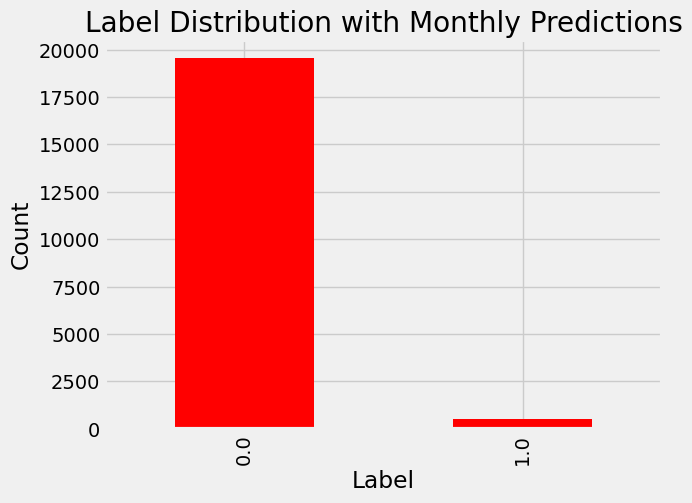

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

label_times['label'].value_counts().plot.bar(color = 'r');
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Label Distribution with Monthly Predictions');
plt.show() 

这（流失预测）是一个不平衡的分类问题。不流失的客户实例远多于流失的客户实例。只要我们在选择用于建模的指标时足够明智，这就不是个问题。

# 第二个预测问题

为了演示如何快速更改问题参数，我们可以将标签函数用于不同的预测问题。 参数定义如下：

**双月流失**

预测日期 = 每月的第一天和第十五天

流失天数 = 14

提前期 = 2 周

预测窗口 = 2 周

In [16]:
label_times = make_label_times(trans, prediction_date = 'SMS', churn_days = 14,
                               lead_time = 1, prediction_window = 1)
label_times.tail(10)

,msno,cutoff_time,label,days_to_churn,churn_date
43,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-10-15,0.0,NaN,NaT
44,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-11-01,0.0,NaN,NaT
45,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-11-15,0.0,NaN,NaT
46,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-12-01,0.0,NaN,NaT
47,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-12-15,0.0,NaN,NaT
48,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-01-01,0.0,NaN,NaT
49,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-01-15,0.0,NaN,NaT
50,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-02-01,0.0,NaN,NaT
51,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-02-15,NaN,NaN,NaT
52,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-03-01,NaN,NaN,NaT


In [17]:
label_times.shape

(49682, 5)

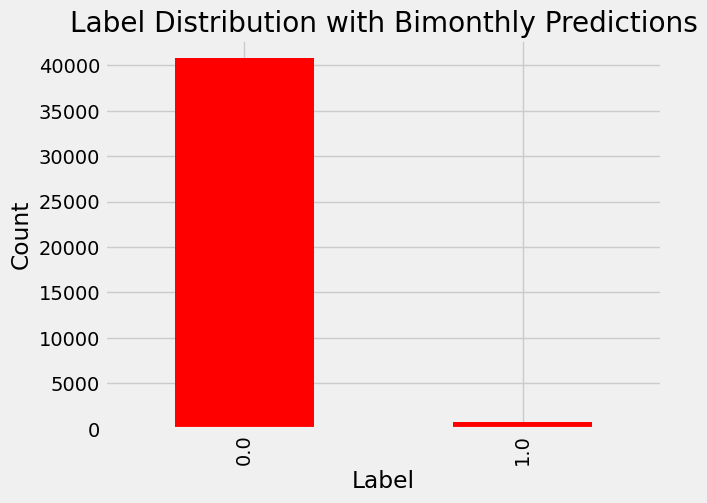

In [18]:
label_times['label'].value_counts().plot.bar(color = 'r');
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Label Distribution with Bimonthly Predictions');
plt.show()

In [19]:
label_times['label'].isnull().sum()

8173

由于问题的设置方式，有很多缺失的标签，当客户没有下一次交易时就会发生这种情况（我们不知道客户的最后一次条目是否为流失）。我们在训练模型时将无法使用这些示例，尽管我们可以为他们进行预测。

# 并行化标签

现在我们有了一个可以从客户交易中生成标签时间表的函数，我们需要标记数据集中的所有客户交易。我们已经将数据分解为 1000 个分区，因此我们可以使用带有 PySpark 的 Spark 并行化此操作。基本思想是编写一个为单个分区生成标签时间表的函数，然后使用单个计算机上的多个内核或计算机集群在所有分区上并行运行此函数。

下面的函数接受一个分区号，从 S3 读取事务数据，为两个预测问题创建标签时间表，并将标签时间表写回 S3。我们可以一次在多个分区上并行运行此函数，因为客户彼此独立。也就是说，一个客户的标签不依赖于任何其他客户的数据。

In [20]:
def partition_to_labels(partition_number, prediction_dates = ['MS', 'SMS'], churn_periods= [31, 14],
                        lead_times = [1, 1], prediction_windows = [1, 1]):
    """
    为单个分区中的所有客户创建标签
    适用于每月一次或每月两次的情况
    
    参数
    --------
        partition (int): 分区号
        label_type (list of str): 'MS' 表示每月标签，
                                  'SMS' 表示双月标签
        churn_periods(list of int): 被视为流失的无有效会员资格的天数
        lead_times (list of int): 提前期（周期数）
        prediction_windows (list of int): 预测窗口（周期数）
    
    返回
    --------
        None: 将带有适当名称的标签数据帧保存到分区目录
    """
    partition_dir = BASE_DIR + 'p' + str(partition_number)  # 'data/partitions/'+ 'p' + num
    
    # 读取数据并筛选异常值
    trans = pd.read_csv(f'{partition_dir}/transactions.csv',
                        # 转时间格式
                        parse_dates=['transaction_date', 'membership_expire_date']) 
    # 将异常数据标记
    # 会员过期日期早于交易日期
    rev = trans[(trans['membership_expire_date'] < trans['transaction_date']) | 
            ((trans['is_cancel'] == 0) & (trans['membership_expire_date'] == trans['transaction_date']))]
    # 会员过期日期与交易日期相同且交易没有被取消
    rev_members = rev['msno'].unique()
    
    # 移除错误数据
    # ~ 是 Python 中的 按位取反 运算符，也叫 逻辑非（NOT）运算符。它用于 反转布尔值 或 按位取反 数值
    trans = trans.loc[~trans['msno'].isin(rev_members)]

    # 创建含有两个标签的 DF
    for prediction_date, churn_days, lead_time, prediction_window in zip(prediction_dates, churn_periods, lead_times, prediction_windows):
        
        cutoff_list = []
            
        # 为所有客户生成标签时间
        # 标签时间的生成依据包括预测日期、流失天数、提前期和预测窗口
        cutoff_list.append(make_label_times(trans, prediction_date = prediction_date, 
                                            churn_days = churn_days, lead_time = lead_time,
                                            prediction_window = prediction_window))
        # 合并并转化为一个整体的 DataFrame
        cutoff_times = pd.concat(cutoff_list)
        cutoff_times = cutoff_times.drop_duplicates(subset = ['msno', 'cutoff_time'])
        
        # 编码以便写入磁盘
        bytes_to_write = cutoff_times.to_csv(None, index = False).encode()

        
        # 写入磁盘  fs.open是向云端写数据，而 with open 是直接写打开的路径内
        with open(f'{partition_dir}/{prediction_date}-{churn_days}_labels.csv', 'wb') as f:
            f.write(bytes_to_write)

In [21]:
# 仅处理分区 p1 中的数据
partition_to_labels(1, prediction_dates = ['MS'], churn_periods = [31], 
                    lead_times = [1], prediction_windows = [1])

In [22]:
label_times = pd.read_csv('/Users/dususu/jupyter_workplace/kkbox-churn-prediction/data/partitions/p1/MS-31_labels.csv')
label_times.tail(10)

,msno,cutoff_time,label,days_to_churn,churn_date
24764,ztr541XHzi0M0EPSrCSUEytFoqKIbZXNiJhszP8vuGw=,2016-08-01,0.0,NaN,NaN
24765,ztr541XHzi0M0EPSrCSUEytFoqKIbZXNiJhszP8vuGw=,2016-09-01,0.0,NaN,NaN
24766,ztr541XHzi0M0EPSrCSUEytFoqKIbZXNiJhszP8vuGw=,2016-10-01,0.0,NaN,NaN
24767,ztr541XHzi0M0EPSrCSUEytFoqKIbZXNiJhszP8vuGw=,2016-11-01,0.0,NaN,NaN
24768,ztr541XHzi0M0EPSrCSUEytFoqKIbZXNiJhszP8vuGw=,2016-12-01,0.0,NaN,NaN
24769,ztr541XHzi0M0EPSrCSUEytFoqKIbZXNiJhszP8vuGw=,2017-01-01,0.0,NaN,NaN
24770,ztr541XHzi0M0EPSrCSUEytFoqKIbZXNiJhszP8vuGw=,2017-02-01,NaN,NaN,NaN
24771,ztr541XHzi0M0EPSrCSUEytFoqKIbZXNiJhszP8vuGw=,2017-03-01,NaN,NaN,NaN
24772,zxHN7E8uhYR9vlOKqRoFetJE03BESH+raGiZ8evjaec=,2017-02-01,NaN,NaN,NaN
24773,zxHN7E8uhYR9vlOKqRoFetJE03BESH+raGiZ8evjaec=,2017-03-01,NaN,NaN,NaN


In [23]:
partition_to_labels(1, prediction_dates = ['SMS'], churn_periods = [14],
                    lead_times = [1], prediction_windows = [1])

In [24]:
label_times = pd.read_csv('/Users/dususu/jupyter_workplace/kkbox-churn-prediction/data/partitions/p1/SMS-14_labels.csv')
label_times.head(10)

,msno,cutoff_time,label,days_to_churn,churn_date
0,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-01-01,0.0,NaN,NaN
1,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-01-15,0.0,NaN,NaN
2,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-02-01,0.0,NaN,NaN
3,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-02-15,0.0,NaN,NaN
4,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-03-01,0.0,NaN,NaN
5,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-03-15,0.0,NaN,NaN
6,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-04-01,0.0,NaN,NaN
7,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-04-15,0.0,NaN,NaN
8,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-05-01,0.0,NaN,NaN
9,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-05-15,0.0,NaN,NaN


# Spark 并行化

下面的代码使用 Spark 来并行化标签的生成。这个实现是基于单台机器的，尽管相同的思路可以扩展到一个机器集群中。

In [25]:
import pyspark

conf = pyspark.SparkConf()

# 启用日志记录
conf.set('spark.eventLog.enabled', True);
conf.set('spark.eventLog.dir', '/Users/dususu/jupyter_workplace/kkbox-churn-prediction/data/churn/tmp');

# 在单台机器上使用所有核心
# 使用一个执行器 executors
conf.set('spark.num.executors', 1)
# 设置每个执行器可用的内存大小为 4GB 
conf.set('spark.executor.memory', '4g')
# 使用 8 个 CPU 核心
conf.set('spark.executor.cores', 8)

# 本地模式，使用所有可用的核心
sc = pyspark.SparkContext(master='local[*]',  
                          appName='labeling', 
                          conf=conf)
from pyspark import SparkContext
if 'sc' in globals():
    sc.stop()
sc = SparkContext(master='local[*]', appName='labeling', conf=conf)

sc

25/02/10 17:39:37 WARN Utils: Your hostname, dususudeMacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.9 instead (on interface en0)
25/02/10 17:39:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/10 17:39:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<SparkContext master=local[*] appName=labeling>

In [26]:
from timeit import default_timer as timer

# 在 Spark 中并行化生成所有标签
start = timer()
sc.parallelize(list(range(1000)), numSlices=1000).\
   map(partition_to_labels).collect()
sc.stop()
end = timer()

当 Spark 正在运行时，您可以访问 localhost:4040 查看特定作业的详细信息，或者访问 localhost:8080 查看集群的概览。这对于诊断 Spark 操作的状态非常有用。

In [27]:
print(f'{round(end - start)} seconds elapsed.')

10027 seconds elapsed.


In [28]:
labels = pd.read_csv('/Users/dususu/jupyter_workplace/kkbox-churn-prediction/data/partitions/p980/MS-31_labels.csv')
labels.tail(10)

,msno,cutoff_time,label,days_to_churn,churn_date
24407,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-06-01,0.0,NaN,NaN
24408,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-07-01,0.0,NaN,NaN
24409,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-08-01,0.0,NaN,NaN
24410,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-09-01,0.0,NaN,NaN
24411,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-10-01,0.0,NaN,NaN
24412,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-11-01,0.0,NaN,NaN
24413,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-12-01,0.0,NaN,NaN
24414,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2017-01-01,0.0,NaN,NaN
24415,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2017-02-01,NaN,NaN,NaN
24416,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2017-03-01,NaN,NaN,NaN


# 结论

客户流失预测工程首先定义了业务需求，然后将其转化为可以通过机器学习解决的任务，并创建了一组标签时间。我们展示了如何定义带有参数的函数，以便可以解决多个预测问题，而无需重新编写整个代码。虽然我们只处理了两个问题，但同样的数据和方法还可以解决许多其他问题。

标签时间包含了特定预测问题的截止时间以及相关的标签。现在，标签时间可以用来根据截止时间过滤数据，为每个标签生成特征。这确保了生成的特征是有效的，并且可以自动在 Featuretools 中处理。

生成标签的一般步骤是：  
	1.	定义业务需求：预测在特定时间段内会流失的客户。  
	2.	将业务需求转化为机器学习问题：给定历史客户数据，构建一个模型，根据多个参数预测哪些客户会流失。  
	3.	生成与机器学习问题相关的标签和截止时间：开发接受参数的函数，以便同一个函数可以用于多个预测问题。  
	4.	为所有历史数据生成标签：通过将数据划分为独立子集来并行化操作。  

这种方法可以扩展到其他问题。尽管确切的语法是针对此用例的，但整体方法旨在通用。